# Named Entity Recognition using Bi-LSTM
- https://wikidocs.net/24682
- 개체명 인식(Named Entity Recognition)이란 말 그대로 이름을 가진 개체(named entity)를 인식하겠다는 것을 의미

## Import

In [1]:
import re
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

## Load dataset

In [3]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [5]:
print(f"Num of samples: {len(tagged_sentences)}")

Num of samples: 6773


## Preprocessing

In [16]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))
len(sentences), len(ner_tags)

(6773, 6773)

In [17]:
sentences[0], ner_tags[0]

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

샘플의 최대 길이 : 60
샘플의 평균 길이 : 13.089916


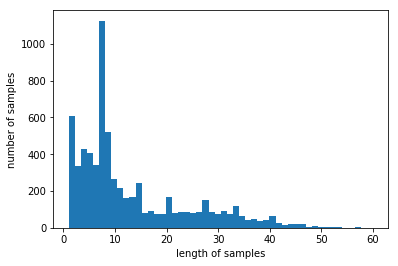

In [12]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### integer encoddding

In [13]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token="OOV")
src_tokenizer.fit_on_texts(sentences)

In [18]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [19]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print(f"Num of words: {vocab_size}")
print(f"Num of taggings: {tag_size}")

Num of words: 4000
Num of taggings: 10


In [20]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)
x_train[0], y_train[0]

([944, 1, 165, 945, 9, 1, 237, 3050, 3], [3, 1, 7, 1, 1, 1, 7, 1, 1])

In [21]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word
len(index_to_word), len(index_to_ner)

(12830, 9)

In [23]:
decoded = []
for index in x_train[0] :
    decoded.append(index_to_word[index])

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'OOV', 'british', 'lamb', '.']


### padding

In [24]:
max_len = 70
x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

### split train, test set

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5418, 70), (1355, 70), (5418, 70), (1355, 70))

In [26]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)
y_train.shape, y_test.shape

((5418, 70, 10), (1355, 70, 10))

## Define model

In [28]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation="softmax")))
model.summary()
# 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 데이터에서 숫자 0은 패딩을 의미하므로 연산에서 제외시킨다는 옵션
# Many-to-Many 문제이므로 LSTM()에 return_sequences=True를 설정

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 128)           512000    
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 512)           788480    
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 10)            5130      
Total params: 1,305,610
Trainable params: 1,305,610
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.001),
    metrics=["accuracy"]
)

## Train

In [30]:
model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=8,
    validation_data=(x_test, y_test)
)

Train on 5418 samples, validate on 1355 samples
Epoch 1/8
5418/5418 [==============================] - 45s 8ms/sample - loss: 0.2170 - accuracy: 0.7976 - val_loss: 0.1466 - val_accuracy: 0.8185
Epoch 2/8
5418/5418 [==============================] - 45s 8ms/sample - loss: 0.1396 - accuracy: 0.8152 - val_loss: 0.1223 - val_accuracy: 0.8172
Epoch 3/8
5418/5418 [==============================] - 51s 9ms/sample - loss: 0.1049 - accuracy: 0.8275 - val_loss: 0.0858 - val_accuracy: 0.8569
Epoch 4/8
5418/5418 [==============================] - 59s 11ms/sample - loss: 0.0775 - accuracy: 0.8737 - val_loss: 0.0670 - val_accuracy: 0.8894
Epoch 5/8
5418/5418 [==============================] - 64s 12ms/sample - loss: 0.0599 - accuracy: 0.9027 - val_loss: 0.0555 - val_accuracy: 0.9089
Epoch 6/8
5418/5418 [==============================] - 50s 9ms/sample - loss: 0.0477 - accuracy: 0.9244 - val_loss: 0.0456 - val_accuracy: 0.9270
Epoch 7/8
5418/5418 [==============================] - 49s 9ms/sample - lo

In [31]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(x_test, y_test, verbose=2)[1]))
# 대부분의 단어가 개체명이 아니라는 'O'가 태깅된 상황에서 예측 정확도가 수많은 'O'로 인해 결정되고 있기 때문에 accuracy는 적절한 metric이 아님
# f1-score 사용을 추천

1355/1 - 4s - loss: 0.0585 - accuracy: 0.9447

 테스트 정확도: 0.9447


## Predict

In [40]:
i = 100
y_predicted = model.predict(np.array([x_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1)
true = np.argmax(y_test[i], axis=-1)
print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(x_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
there            : O       O
was              : O       O
also             : O       O
heavy            : O       O
security         : O       O
in               : O       O
the              : O       O
OOV              : O       O
centre           : O       O
of               : O       O
amman            : B-LOC   B-LOC
,                : O       O
where            : O       O
OOV              : O       O
clashes          : O       O
had              : O       O
erupted          : O       O
last             : O       O
saturday         : O       O
,                : O       O
but              : O       O
friday           : O       O
prayers          : O       O
at               : O       O
the              : O       O
main             : O       O
mosque           : O       O
ended            : O       O
OOV              : O       O
as               : O       O
police           : O       O
in               : O       O
full  